In [1]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import scipy as sc
from twitterSentiment.models import (CompanyStocksSentimentHistory,Company, CompanyFinancials, TwitterText, 
CompanyAltmanZscore, CompanySentiment, CompanyKeyStats)
from django.db.models import Q

In [2]:
def company_sentiment_calculations(companyid):
    try:
        company_sentiments = CompanySentiment.objects.filter(company_id=companyid).values()
        if company_sentiments.count() >0:
            company_sentiments_list = pd.DataFrame(list(company_sentiments))
            averages = pd.Series([company_sentiments_list['sentiment_prob_very_negative'].astype(float).sum(),
                company_sentiments_list['sentiment_prob_negative'].astype(float).sum(),
                company_sentiments_list['sentiment_prob_neutral'].astype(float).sum(),
                company_sentiments_list['sentiment_prob_positive'].astype(float).sum(),
                company_sentiments_list['sentiment_prob_very_positive'].astype(float).sum()],
                index=[0,1,2,3,4])
            return (averages.idxmax(axis=1)) #pick the index with the maximum probability
        else:
            return 
    except:
        print ("sentiment error occured for company:", companyid, "error:",sys.exc_info())
        return (-1)

    
def company_zscore_calculations(companyid):
    try:
        company_zscore = CompanyAltmanZscore.objects.all().filter(company_id=companyid).values('zscore')
        r = list(company_zscore[:1])
        if r:
            return r[0]['zscore']
        return 

    except:
        print ("zscore error occured for company:", companyid, "error:",sys.exc_info())
        return (-1)

def build_data_file():
    ##use this method to create the companysentimentzscore for the analysis
    companylist = pd.DataFrame(list(Company.objects.filter(~Q(marketCap=None).values())))
    print("total companies listed",companylist.count())
    companylist['sentiment']=companylist[['id']].apply(company_sentiment_calculations, axis=1)
    companylist['altman']=companylist[['id']].apply(company_zscore_calculations, axis=1)
    companylistix = companylist.set_index(['id'])
    companylistix.to_csv("companysentimentszscore.csv")

Altman Z-Score for Sampled Firms (Table 14)

In [3]:
companyinfo= pd.read_csv("companysentimentszscore.csv")
print ("Total Firms: ", companyinfo.count())
altmanzscore = companyinfo.altman
distress = companyinfo.altman[companyinfo.altman<=1.8]
safe = companyinfo.altman[companyinfo.altman>=3.0]
neutral = companyinfo.altman[companyinfo.altman.between(1.8,3)]
print ("****Distress:", distress.count(), ",Safe:",safe.count(), ",Neutral:",neutral.count())
print ("\n\n****Description for Financially-Distressed Firms Altman < 1.8")
print (distress.describe())
print ("\n\n****Description for Neutral Firms Altman > 1.8 & < 3.0")
print (neutral.describe())
print ("\n\n****Description for Safe Firms >= 3.0")
print (safe.describe())

Total Firms:  id                5787
adrTso            5787
date_extracted    5787
exchange          5787
industry          5787
ipoYear           5787
lastSale          5787
marketCap         5787
name              5787
sector            5787
summaryQuote      5787
symbol            5787
sentiment         3985
altman            3313
dtype: int64
****Distress: 1032 ,Safe: 1690 ,Neutral: 591


****Description for Financially-Distressed Firms Altman < 1.8
count    1032.000000
mean       -1.961134
std         9.818075
min      -157.210000
25%        -1.091750
50%         0.663500
75%         1.255500
max         1.798000
Name: altman, dtype: float64


****Description for Neutral Firms Altman > 1.8 & < 3.0
count    591.000000
mean       2.374411
std        0.337121
min        1.801000
25%        2.092500
50%        2.375000
75%        2.663500
max        2.997000
Name: altman, dtype: float64


****Description for Safe Firms >= 3.0
count    1690.000000
mean        9.925705
std        20.506

In [4]:
companies = companyinfo[~(companyinfo.sentiment.isnull()) & ~(companyinfo.altman.isnull()) & ~(companyinfo.sector.isin(['Finance']))]
print (companies.describe())

                id     lastSale     marketCap    sentiment       altman
count  2618.000000  2618.000000  2.618000e+03  2618.000000  2618.000000
mean   3118.103132    36.625553  9.044559e+09     2.158136     4.643611
std    1921.975390    51.212159  3.000794e+10     0.667646    12.866519
min       6.000000     0.100000  2.102689e+06     0.000000  -153.814000
25%    1490.750000     6.960000  2.736628e+08     2.000000     1.372000
50%    2955.500000    22.610000  1.333308e+09     2.000000     3.035500
75%    4747.500000    49.590000  5.094740e+09     2.000000     5.489500
max    6674.000000  1135.970000  6.744566e+11     4.000000   269.368000



**** Sentiments Breakdown sentiment
0              18
1             137
2            2094
3             151
4             218
Name: sentiment, dtype: int64

****Sentiments by Main Categories sentiment
-1            155
 0           2094
 1            369
Name: sentiment, dtype: int64

**** Sentiments Breakdown Excluding Neutral
Axes(0.125,0.125;0.775x0.775)

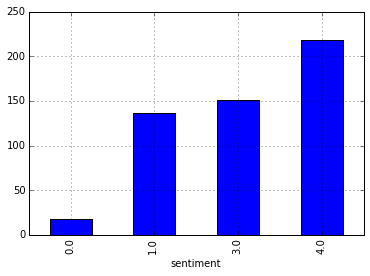

In [5]:
def altmanscale(value):
    if value <=1.8:
        return -1
    elif (value>1.8) & (value<3.0):
        return 0
    else:
        return 1
def sentimentscale(value):
    if value <2:
        return -1
    elif value ==2:
        return 0
    else:
        return 1
def sentimentsstr(value):
    if value <2:
        return "negative"
    elif value ==2:
        return "neutral"
    else:
        return "positive"
    
def stockmovementstr(value):
    if value ==1:
        return "negative"
    elif value ==0:
        return "neutral"
    else:
        return "positive"
    

##sentiments plots excluding neutral
sentiments = companies.groupby('sentiment')['sentiment']
print ("\n**** Sentiments Breakdown",sentiments.count())

companies.altmanscale = companies.altman.apply(altmanscale)
companies.sentimentscale = companies.sentiment.apply(sentimentscale)
print ("\n****Sentiments by Main Categories",companies.sentimentscale.groupby(companies.sentimentscale).count())
print ("\n**** Sentiments Breakdown Excluding Neutral")
print(companies[~(companies.sentiment==2)].groupby('sentiment')['sentiment'].count().plot(kind="bar"))

In [6]:
from scipy.stats.mstats import normaltest
print ("\n****Test for Normality:")
print ("normal test for sentiment",normaltest(companies.sentiment))
print ("normal test for altman",normaltest(companies.altman))
print ("a P close to zero indidicated that the data is not normal")


****Test for Normality:
normal test for sentiment (679.21183752063507, 3.2435713873994668e-148)
normal test for altman (3404.2039999564081, 0.0)
a P close to zero indidicated that the data is not normal


In [7]:
print ("Spearman correlation between sentiment and altman scales:",sc.stats.spearmanr(companies.sentimentscale, companies.altmanscale))
print ("a P>0.05 indicates no statistically significant correlation")

Spearman correlation between sentiment and altman scales: (-0.030236069863026162, 0.12193910694076453)
a P>0.05 indicates no statistically significant correlation


In [8]:
print ("correlation analysis by sector")
print ("For basic industries:","(",companies.sector[companies.sector=="Basic Industries"].count()," firms)", 
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Basic Industries"].rank(method="average", ascending=True), 
       companies.sentimentscale[companies.sector=="Basic Industries"].rank(method="average", ascending=True)))
print ("For capital goods: ","(",companies.sector[companies.sector=="Capital Goods"].count()," firms)",
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Capital Goods"], 
                          companies.sentimentscale[companies.sector=="Capital Goods"]))
print ("Consumer Durables: ","(",companies.sector[companies.sector=="Consumer Durables"].count()," firms)",
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Consumer Durables"], 
                          companies.sentimentscale[companies.sector=="Consumer Durables"]))
print ("Consumer NonDurables: ","(",companies.sector[companies.sector=="Consumer Non-Durables"].count()," firms)",
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Consumer Non-Durables"], 
                          companies.sentimentscale[companies.sector=="Consumer Non-Durables"]))
print ("Consumer Services: ","(",companies.sector[companies.sector=="Consumer Services"].count()," firms)",
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Consumer Services"], 
                          companies.sentimentscale[companies.sector=="Consumer Services"]))
print ("Energy","(",companies.sector[companies.sector=="Energy"].count()," firms)", 
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Energy"], companies.sentimentscale[companies.sector=="Energy"]))
print ("Healthcare","(",companies.sector[companies.sector=="Health Care"].count()," firms)", 
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Health Care"], companies.sentimentscale[companies.sector=="Health Care"]))
print ("Miscellaneous","(",companies.sector[companies.sector=="Miscellaneous"].count()," firms)", 
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Miscellaneous"], companies.sentimentscale[companies.sector=="Miscellaneous"]))
print ("Public Utilities","(",companies.sector[companies.sector=="Public Utilities"].count()," firms)", 
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Public Utilities"], companies.sentimentscale[companies.sector=="Public Utilities"]))
print ("Technology","(",companies.sector[companies.sector=="Technology"].count()," firms)",
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Technology"], companies.sentimentscale[companies.sector=="Technology"]))
print ("Transportation","(",companies.sector[companies.sector=="Transportation"].count()," firms)",
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="Transportation"], companies.sentimentscale[companies.sector=="Transportation"]))
print ("N/a","(",companies.sector[companies.sector=="n/a"].count()," firms)", 
       sc.stats.spearmanr(companies.altmanscale[companies.sector=="n/a"], companies.sentimentscale[companies.sector=="n/a"]))

correlation analysis by sector
For basic industries: ( 233  firms) (-0.057604509123855778, 0.38141460299857033)
For capital goods:  ( 253  firms) (0.066972348438911422, 0.28860940659082662)
Consumer Durables:  ( 100  firms) (0.055661386982693427, 0.58229018517890074)
Consumer NonDurables:  ( 170  firms) (-0.086183593701254654, 0.26378632495570026)
Consumer Services:  ( 397  firms) (-0.020205811438471499, 0.68814813451527768)
Energy ( 212  firms) (-0.21930040287038272, 0.0013117767964922885)
Healthcare ( 427  firms) (-0.04725238360919258, 0.33000480612483729)
Miscellaneous ( 102  firms) (-0.048251155119557368, 0.63009898687019883)
Public Utilities ( 138  firms) (-0.026246287152440182, 0.75993037837830979)
Technology ( 499  firms) (-0.053218159188588389, 0.23536046951436518)
Transportation ( 81  firms) (-0.047156968264577326, 0.6759114012086983)
N/a

 ( 6  firms) (-0.33333333333333331, 0.51851851851851827)


In [9]:
print ("****correlation analysis for financially distressed firms:")
print (sc.stats.spearmanr(companies.sentimentscale[companies.altmanscale==-1], companies.altman[companies.altmanscale==-1]))
print ("p>0.05 indiciates no significance")

****correlation analysis for financially distressed firms:
(-0.058611960064478115, 0.092492396411079425)
p>0.05 indiciates no significance


In [19]:
dailydata = pd.DataFrame(list(CompanyStocksSentimentHistory.objects.filter(~Q(sentiment=None) & ~Q(stockdirection=None)).values()))
dailydata.sentimentsstr = dailydata.sentiment.apply(sentimentsstr)
dailydata.stockmovementstr = dailydata.stockdirection.apply(stockmovementstr)
dailydata.sentimentscale = dailydata.sentiment.apply(sentimentscale)
#print ("Dataset on Sentiment excluding days with no sentiments or no stock movements:\n",
#       dailydata.sentimentsstr.groupby([dailydata.date,dailydata.sentimentsstr]).count())
#print ("Dataset on Stock Movement excluding days with no sentiments or no stock movements:\n",
#       dailydata.stockmovementstr.groupby([dailydata.date,dailydata.stockmovementstr]).count())
print ("total tweets with sentiments and stock value: ", dailydata.tweet_count.sum())
print ("correlation between sentiment and stock direction:",sc.stats.spearmanr(dailydata.sentiment,  dailydata.stockdirection))
print ("correlation between sentiment scale and stock direction:",sc.stats.spearmanr(dailydata.sentiment,  dailydata.stockdirection))


dailydata = pd.DataFrame(list(CompanyStocksSentimentHistory.objects.filter(~Q(sentiment=None)).values()))
print ("total tweets with sentiments: ", dailydata.tweet_count.sum())
print ("correlation between sentiment and tweet count:",sc.stats.spearmanr(dailydata.sentiment,  dailydata.tweet_count))
dailydata.sentimentscale = dailydata.sentiment.apply(sentimentscale)
print ("correlation between distress/safe stocks and stock direction",
       sc.stats.spearmanr(dailydata.sentimentscale[dailydata.sentimentscale != 2], dailydata.stockdirection))

total tweets with sentiments and stock value:  35726
correlation between sentiment and stock direction: (-0.0050123386944458297, 0.67249850944176182)
correlation between sentiment scale and stock direction: (-0.0050123386944458297, 0.67249850944176182)
total tweets with sentiments: 

 66038
correlation between sentiment and tweet count: (-0.12071759517158794, 2.3157593866886628e-35)
correlation between distress/safe stocks and stock direction (0.014313482237576216, 0.14261916055802118)
